In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c playground-series-s3e20

 96% 47.0M/48.9M [00:03<00:00, 20.3MB/s]
100% 48.9M/48.9M [00:03<00:00, 14.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/playground-series-s3e20.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

import branca.colormap as cm
import seaborn as sns
import folium

# Load data

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Data analysis

In [ ]:
train_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [ ]:
{column.split('_')[0] for column in train_df.columns}

{'CarbonMonoxide',
 'Cloud',
 'Formaldehyde',
 'ID',
 'NitrogenDioxide',
 'Ozone',
 'SulphurDioxide',
 'UvAerosolIndex',
 'UvAerosolLayerHeight',
 'emission',
 'latitude',
 'longitude',
 'week',
 'year'}

In [ ]:
missing_values = train_df.isnull().sum()
missing_values[missing_values>0].sort_values(ascending=False).head(20)

UvAerosolLayerHeight_aerosol_pressure                      78584
UvAerosolLayerHeight_solar_zenith_angle                    78584
UvAerosolLayerHeight_aerosol_height                        78584
UvAerosolLayerHeight_aerosol_optical_depth                 78584
UvAerosolLayerHeight_sensor_zenith_angle                   78584
UvAerosolLayerHeight_sensor_azimuth_angle                  78584
UvAerosolLayerHeight_solar_azimuth_angle                   78584
NitrogenDioxide_NO2_slant_column_number_density            18320
NitrogenDioxide_tropopause_pressure                        18320
NitrogenDioxide_tropospheric_NO2_column_number_density     18320
NitrogenDioxide_absorbing_aerosol_index                    18320
NitrogenDioxide_cloud_fraction                             18320
NitrogenDioxide_sensor_altitude                            18320
NitrogenDioxide_sensor_azimuth_angle                       18320
NitrogenDioxide_sensor_zenith_angle                        18320
NitrogenDioxide_solar_azi

In [ ]:
# find distinct pairs of latitude and logitude
distinct_location = train_df.groupby(['latitude','longitude']).ngroups
print(f'Number of distinct latitude-longitude pairs: {distinct_location}')

Number of distinct latitude-longitude pairs: 497


This means that we have 497 distinct geographical locations from where we collected this data.

In [ ]:
# find over how many years the data has been collected
num_years = train_df.groupby(['year']).ngroups
print("Number of distinct years: ", {num_years})
years = train_df['year'].unique()
print("The years for which the data has been collected is: ", years)

Number of distinct years:  {3}
The years for which the data has been collected is:  [2019 2020 2021]


In [ ]:
# find how many weeks are present
num_weeks = train_df.groupby(['week_no']).ngroups
print("Number of weeks present: ", num_weeks)

Number of weeks present:  53


So, number of latitude-longitude pairs * number of years * weeks should be equal to number of rows present in the data

In [ ]:
distinct_location * num_years * num_weeks

79023

This is equal to size of our training data.

In [ ]:
train_plot = train_df.copy(deep=True)
train_plot['date'] = pd.to_datetime(train_plot['year'].astype(str)
                        + '-' + train_plot['week_no'].astype(str)
                        + '-1', format='%Y-%W-%w')
train_plot.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission,date
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994,2018-12-31
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176,2019-01-07
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381,2019-01-14
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286,2019-01-21
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317,2019-01-28


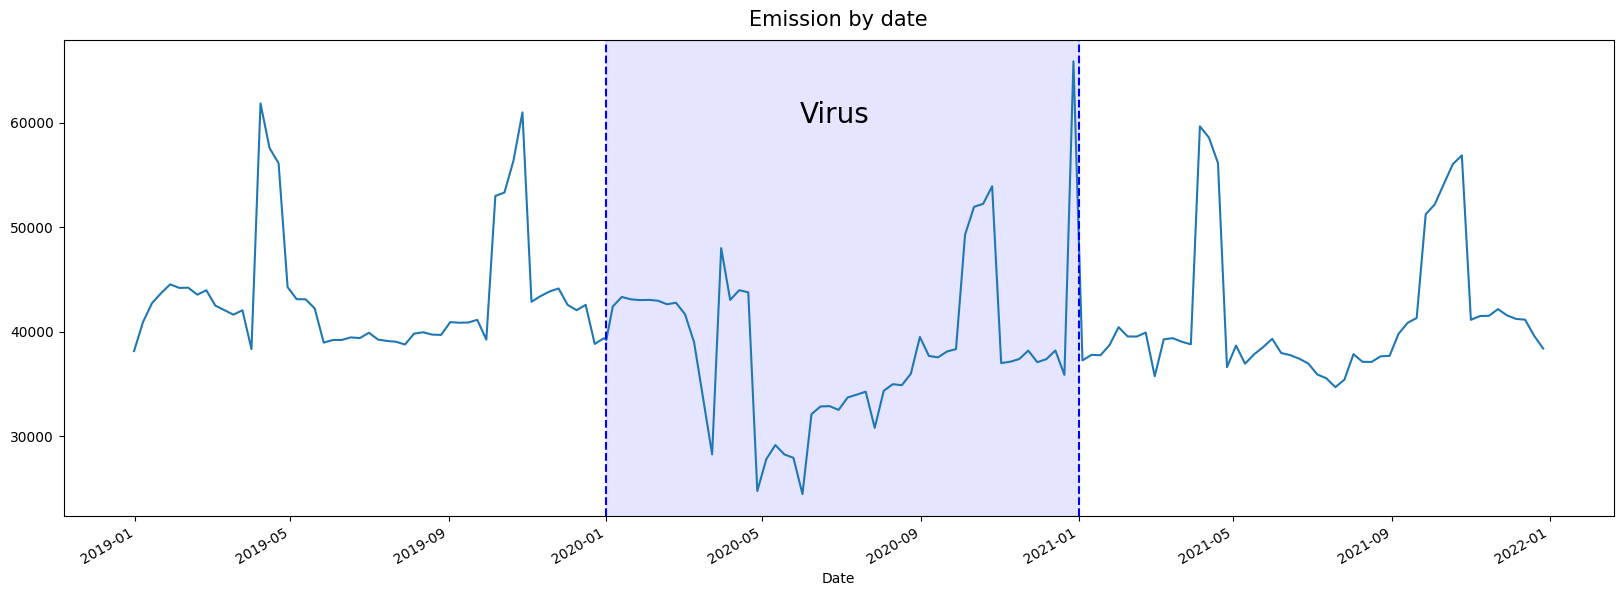

In [ ]:
# Taken from https://www.kaggle.com/code/kacperrabczewski/rwanda-co2-defeat-global-warming/notebook
train_plot.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='Date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='blue', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='blue')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='blue')

plt.text(pd.Timestamp ('2020-05-30'), 60000, "Virus", size = 20)

plt.title('Emission by date', size=15, pad=10)
plt.show()

We can see that the total emission during COVID was significantly less as compared to other years.

In [ ]:
emission_zero = train_df.groupby(['latitude','longitude'])['emission'].mean()
emission_zero[emission_zero == 0]

latitude  longitude
-2.898    29.002       0.0
-2.859    29.041       0.0
-2.841    29.159       0.0
-2.817    29.283       0.0
-2.496    28.504       0.0
-1.974    28.526       0.0
-1.839    28.761       0.0
-1.833    28.467       0.0
-1.730    28.470       0.0
-1.712    28.688       0.0
-1.696    28.304       0.0
-1.682    29.218       0.0
-1.532    28.568       0.0
-1.505    30.995       0.0
-1.328    28.872       0.0
Name: emission, dtype: float64

There are 15 locations where the mean emission is 0.

In [ ]:
# Let's find max emission value
emission_highest = train_df.groupby(['latitude','longitude'])['emission'].sum()
emission_highest.sort_values(ascending=False).head(10)

latitude  longitude
-2.378    29.222       355115.62890
-2.079    29.321       194279.95637
-1.346    31.254        75570.97297
-0.956    30.744        72408.28823
-1.342    31.358        65127.49235
-2.441    28.959        62884.41243
-2.599    29.801        56132.05154
-1.847    30.953        55175.79754
-2.293    29.507        53455.79490
-1.889    29.611        51644.60904
Name: emission, dtype: float64

There are 2 locations which have unusually high amount of emissions.

In [ ]:
# Taken from https://www.kaggle.com/code/kacperrabczewski/rwanda-co2-defeat-global-warming/notebook
grouped = train_df.groupby(['latitude','longitude'])['emission'].sum().reset_index()
colormap = cm.LinearColormap(['green', 'red'], vmin=0, vmax=75000)


m = folium.Map(location=[grouped['latitude'].mean(), grouped['longitude'].mean()])

for _, row in grouped.iterrows():
    rows_emission = row['emission']
    color = 'blue' if rows_emission == 0 else colormap(rows_emission) if rows_emission < 10**5 else 'black'
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=np.sqrt(row['emission'])*15,
        color=color,
        fill=True,
        fill_color= color
    ).add_to(m)

# Fit the map to the bounds of markers
m.fit_bounds(m.get_bounds())

# Display the map
m

There are 2 locations where the emission is very high. This is represented by black circles

<Axes: >

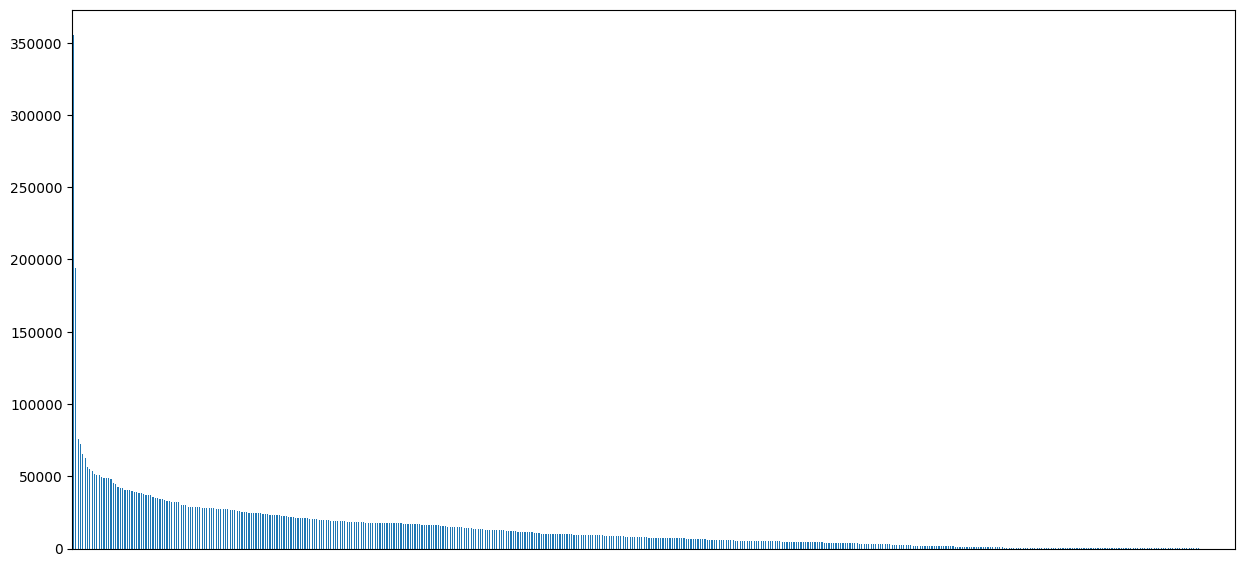

In [ ]:
grouped['emission'].sort_values(ascending=False).plot(kind = 'bar', figsize=(15, 7), xticks=[])

Clearly 2 locations have very high emission.

# Feature engineering

In [ ]:
train_df.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

Let's try to correct the low emission during covid.

In [ ]:
avg_emission_no_covid = train_df[train_df['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

In [ ]:
avg_emission_covid = train_df[train_df['year']==2020].groupby('week_no')['emission'].mean()
avg_emission_covid

week_no
0      78.886566
1      85.334366
2      87.161311
3      86.704958
4      86.562860
5      86.603966
6      86.443357
7      85.763466
8      86.051223
9      83.820554
10     78.453283
11     67.656420
12     56.860039
13     96.568241
14     86.594708
15     88.467146
16     88.051859
17     49.798797
18     55.941798
19     58.645345
20     56.835315
21     56.186080
22     49.201182
23     64.597895
24     66.077803
25     66.140400
26     65.412992
27     67.807094
28     68.345387
29     68.921350
30     61.961884
31     69.094868
32     70.366004
33     70.169397
34     72.379983
35     79.455140
36     75.805656
37     75.530563
38     76.657110
39     77.127968
40     99.156091
41    104.528618
42    105.095806
43    108.478833
44     74.435716
45     74.685331
46     75.212110
47     76.836120
48     74.603733
49     75.190878
50     76.859428
51     72.155911
52     71.899535
Name: emission, dtype: float64

In [ ]:
ratio = avg_emission_no_covid/avg_emission_covid
ratio

week_no
0     0.870728
1     0.921803
2     0.929442
3     0.944860
4     0.967534
5     0.982937
6     0.974686
7     0.974460
8     0.980573
9     0.938945
10    1.042898
11    1.204472
12    1.434507
13    0.803406
14    1.411540
15    1.320776
16    1.282716
17    1.633726
18    1.470678
19    1.372899
20    1.416986
21    1.387121
22    1.605413
23    1.201736
24    1.175458
25    1.168071
26    1.181872
27    1.114895
28    1.098765
29    1.076050
30    1.204370
31    1.130717
32    1.101689
33    1.101387
34    1.074776
35    0.995194
36    1.070464
37    1.088473
38    1.081914
39    1.180094
40    1.067035
41    1.034021
42    1.075738
43    1.093097
44    1.135193
45    1.143523
46    1.141802
47    1.129784
48    1.134357
49    1.114163
50    1.095724
51    1.093626
52    1.087913
Name: emission, dtype: float64

In [ ]:
train_df.loc[train_df['year'] == 2020, 'emission'] *= train_df['week_no'].map(ratio)

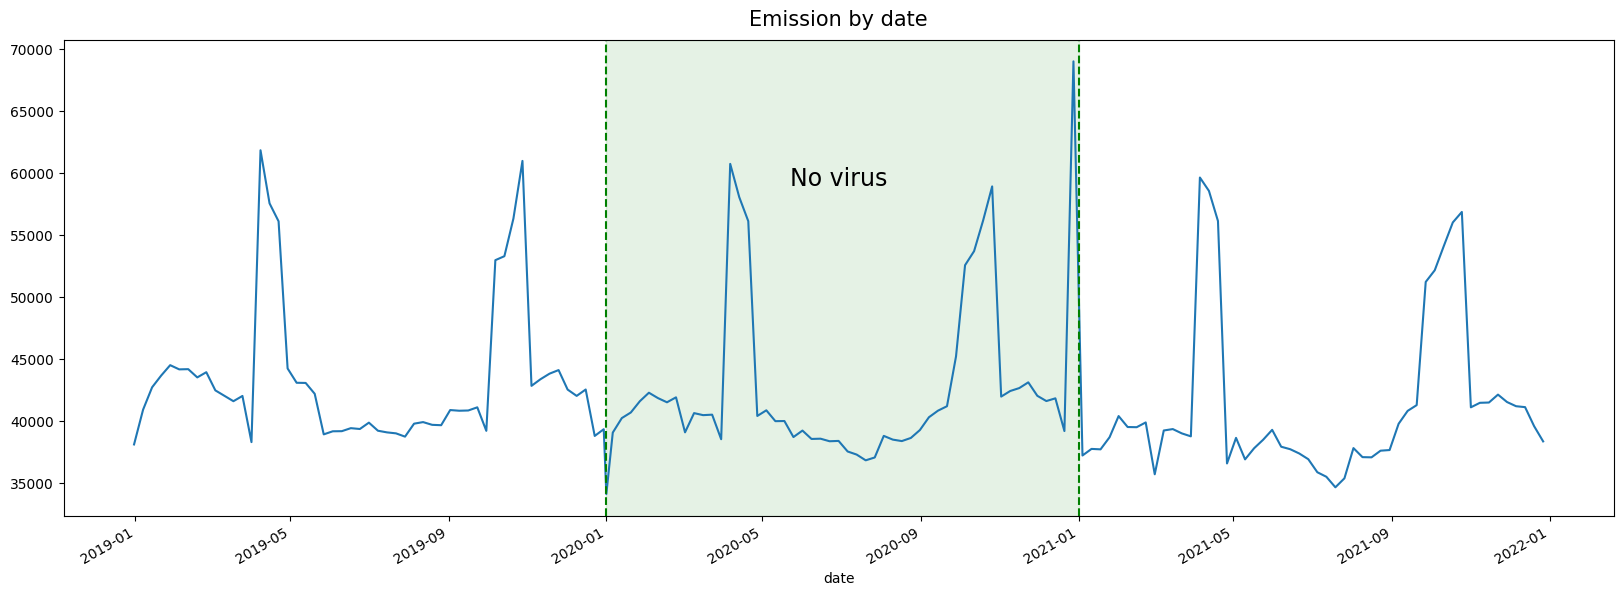

In [ ]:
train_df['date'] = pd.to_datetime(train_df['year'].astype(str) + '-' + train_df['week_no'].astype(str) + '-1', format='%Y-%W-%w')
train_df.groupby(['date'])['emission'].sum().plot(kind='line', figsize=(20, 7), xlabel='date')

plt.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'), color='green', alpha=0.1)
plt.axvline(pd.Timestamp('2020-01-01'), linestyle = "--", color='green')
plt.axvline(pd.Timestamp('2021-01-01'), linestyle = "--", color='green')

plt.text(pd.Timestamp('2020-05-22'), 59000, "No virus", size = 17)

plt.title('Emission by date', size=15, pad=10)
plt.show()


In [ ]:
train_df['season'] = train_df['date'].dt.month.apply(lambda x:
                                                     1 if 3 <= x <= 5
                                                     else 2 if 6 <= x <= 8
                                                     else 3 if 9 <= x <= 11
                                                     else 4)

Capturing the cyclic nature of months, weeks and seasons.

In [ ]:
train_df['month_sin'] = np.sin(train_df['date'].dt.month*2*np.pi / 12)
train_df['month_cos'] = np.cos(train_df['date'].dt.month*2*np.pi / 12)

train_df['week_sin'] = np.sin(train_df['week_no']*2*np.pi / 53)
train_df['week_cos'] = np.cos(train_df['week_no']*2*np.pi / 53)

train_df['season_sin'] = np.sin(train_df['season']*2*np.pi / 4)
train_df['season_cos'] = np.cos(train_df['season']*2*np.pi / 4)

In [ ]:
X = train_df.drop(['emission'], axis = 1)
Y = train_df['emission']

In [ ]:
pipeline = make_pipeline(
    SimpleImputer(),
    QuantileTransformer(output_distribution='normal'),
    StandardScaler()
)

In [ ]:
features = ['latitude', 'longitude', 'year', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'season_sin', 'season_cos']

In [ ]:
X_transformed = pipeline.fit_transform(X[features]) # returns numpy array

In [ ]:
X_transformed = pd.DataFrame(X_transformed, columns=pipeline.get_feature_names_out())
X_transformed.head()

,latitude,longitude,year,week_sin,week_cos,month_sin,month_cos,season_sin,season_cos
0,5.048457,-0.626784,-1.225335,0.005432,3.542253,-0.054405,2.268891,-0.096135,1.405714
1,5.048457,-0.626784,-1.225335,0.074125,1.166907,0.186996,0.460849,-0.096135,1.405714
2,5.048457,-0.626784,-1.225335,0.140619,1.004997,0.186996,0.460849,-0.096135,1.405714
3,5.048457,-0.626784,-1.225335,0.214157,0.881390,0.186996,0.460849,-0.096135,1.405714
4,5.048457,-0.626784,-1.225335,0.290894,0.755368,0.186996,0.460849,-0.096135,1.405714


# Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.2, random_state=41)
X_train.head()

,latitude,longitude,year,week_sin,week_cos,month_sin,month_cos,season_sin,season_cos
7320,1.273197,-0.226988,-1.224745e+00,0.443314,0.527774,0.355387,0.166208,-0.098645,1.410495
37108,0.076497,0.472798,-7.682673e-12,0.629698,0.411552,0.355387,0.166208,-0.098645,1.410495
4928,1.464143,0.600867,1.224745e+00,-0.067430,1.314172,-0.049801,2.266775,-0.098645,1.410495
58655,-0.622376,-0.867282,1.224745e+00,-0.937593,-0.156391,-2.337533,-0.064043,-1.423733,-0.089871
19641,0.664818,-0.291119,-7.682673e-12,-0.330801,-0.619729,-0.390673,-0.272171,0.078687,-1.403943


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(X_transformed, Y)

RandomForestRegressor()

In [ ]:
# 3 groups for 2019, 2020 and 2021
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import mean_squared_error
gkf = GroupKFold(3)

scores = -cross_val_score(model_rf, X_transformed, Y, scoring="neg_root_mean_squared_error", cv=gkf.split(X_transformed, Y, groups=train_df['year']))

print(f'Training RMSE: {mean_squared_error(Y, model_rf.predict(X_transformed), squared=False):.2f}')
print(f"Cross validation RMSE: {scores.mean():.2f}")

Training RMSE: 5.14
Cross validation RMSE: 18.74


Now let's prepare the test data

In [ ]:
test_df['date'] = pd.to_datetime(test_df['year'].astype(str) + '-' +
                                 test_df['week_no'].astype(str) +
                                 '-1', format='%Y-%W-%w')


In [ ]:
test_df.drop(columns=['UvAerosolLayerHeight_aerosol_pressure', 'UvAerosolLayerHeight_solar_zenith_angle', 'UvAerosolLayerHeight_aerosol_height', 'UvAerosolLayerHeight_aerosol_optical_depth', 'UvAerosolLayerHeight_sensor_zenith_angle', 'UvAerosolLayerHeight_sensor_azimuth_angle', 'UvAerosolLayerHeight_solar_azimuth_angle'], inplace=True)

In [ ]:
test_df['season'] = test_df['date'].dt.month.apply(lambda x:
                                                     1 if 3 <= x <= 5
                                                     else 2 if 6 <= x <= 8
                                                     else 3 if 9 <= x <= 11
                                                     else 4)

In [ ]:
test_df['month_sin'] = np.sin(test_df['date'].dt.month*2*np.pi / 12)
test_df['month_cos'] = np.cos(test_df['date'].dt.month*2*np.pi / 12)

test_df['week_sin'] = np.sin(test_df['week_no']*2*np.pi / 53)
test_df['week_cos'] = np.cos(test_df['week_no']*2*np.pi / 53)

test_df['season_sin'] = np.sin(test_df['season']*2*np.pi / 4)
test_df['season_cos'] = np.cos(test_df['season']*2*np.pi / 4)

In [ ]:
test_transformed = pipeline.transform(test_df[features])
test_transformed = pd.DataFrame(test_transformed, columns=pipeline.get_feature_names_out())
test_transformed.head()

,latitude,longitude,year,week_sin,week_cos,month_sin,month_cos,season_sin,season_cos
0,5.048457,-0.626784,1.224153,0.005432,3.542253,-0.054405,2.268891,-0.096135,1.405714
1,5.048457,-0.626784,1.224153,0.074125,1.166907,0.186996,0.460849,-0.096135,1.405714
2,5.048457,-0.626784,1.224153,0.140619,1.004997,0.186996,0.460849,-0.096135,1.405714
3,5.048457,-0.626784,1.224153,0.214157,0.881390,0.186996,0.460849,-0.096135,1.405714
4,5.048457,-0.626784,1.224153,0.290894,0.755368,0.186996,0.460849,-0.096135,1.405714


In [ ]:
test_predictions = model_rf.predict(test_transformed)
test_predictions

array([ 3.32218161,  3.96503347,  4.04422496, ..., 29.78375294,
       30.041606  , 29.66305108])

In [ ]:
test_predictions[test_predictions<0] = 0

In [ ]:
submission = pd.DataFrame({
    'ID_LAT_LON_YEAR_WEEK': test_df['ID_LAT_LON_YEAR_WEEK'],  # Replace 'ID_LAT_LON_YEAR_WEEK' with the actual ID column in your test data
    'emission': test_predictions * 1.07
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)